In [1]:
%load_ext autoreload
%autoreload 2

# Comment to make figures visible in html version of the notebook
# %matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from functools import lru_cache, reduce
from zwad.ad import ZtfAnomalyDetector


algos_for_fields = {
    'm31': ['iso', 'gmm', 'svm', 'lof'],
    'deep': ['iso', 'gmm', 'svm'],
    'disk': ['iso', 'gmm'],
}

jobs = '4'
data_dir = os.path.join('..', 'data')
fake_dir = os.path.join(data_dir, 'fakes')
scalings = ['std', 'pca', 'pca15', 'pca24', 'norm']


# Contents

* [Code](#Code)
* [Generating score files with different scalings](#Generating-score-files-with-scalings)
* [Compare fake detection with different scalings](#Compare-fake-detection-with-scalings)
* [Generating score files for different fields](#Generating-score-files-for-different-fields)
* [Plot the fake detection curves for fields](#Plot-the-fake-detection-curves-for-fields)
* [Plot the cumulative score distributions](#Plot-the-cumulative-score-distributions)

# Code

In [3]:
@lru_cache()
def load_fake_names(fake_filename):
    """
    Just load the fake names, in tuple.
    """
    return tuple(pd.read_csv(fake_filename, index_col=0)['0'])


def fake_indices(scores, fake_names):
    """
    Calculate fake indices
    
    Parameters
    ----------
    scores: Scores of all the objects, including fakes at the end.
    
    fake_names: Tuple of fake object names.
    
    Return
    ------
    Table with 'name' and 'order' columns, sorted by 'order'.
    """
    fake_n = len(fake_names)
    index = np.argsort(scores)
    fake_index = np.argsort(index)[-fake_n:]  # Guess what's going on here ;)
    fake_table = pd.DataFrame({'order': fake_index, 'name': fake_names})
    return fake_table.sort_values(by='order').reset_index(drop=True)


def union_fakes(algo_to_fakes):
    """
    Union the different algorithms' fake detection curves to one
    """
    
    order = []
    for fake_table in algo_to_fakes.values():
        order.append(fake_table.sort_values(by='name')['order'].to_numpy())

    name = sorted(fake_table['name'])
    min_order = np.array(order).min(axis=0)

    table = pd.DataFrame({'order': min_order, 'name': name})
    table = table.sort_values(by='order').reset_index(drop=True)
    
    return table


def make_fake_tables(scores_dir, fake_dir, field, algos):
    """
    Read the score files with fakes. Read the fake descriptions.
    Make the tables with score oderings.
    """
    fake_tables = {}
    for algo in algos:
        scores = np.memmap(os.path.join(scores_dir, 'score_{}_{}_fake.dat'.format(field, algo)), dtype=np.float64)
        fake_names = load_fake_names(os.path.join(fake_dir, 'fakes_{}_fake.csv'.format(field)))
        fake_tables[algo] = fake_indices(scores, fake_names)
    
    fake_tables['union'] = union_fakes(fake_tables)
    return fake_tables

# Generating score files with scalings

In [4]:
# Generate the score files for m31 field with different scalings

field = 'm31'
for scaling in scalings:
    # Put score files in different directories for future comparison
    scores_dir = os.path.join(data_dir, 'scores_' + scaling)
    os.makedirs(scores_dir, exist_ok=True)

    for algo in algos_for_fields[field]:
        real_args = ['--oid', os.path.join(data_dir, 'oid_{}.dat'.format(field)),
                     '--feature', os.path.join(data_dir, 'feature_{}.dat'.format(field)),]
        fake_args = ['--oid', os.path.join(fake_dir, 'oid_{}_fake.dat'.format(field)),
                     '--feature', os.path.join(fake_dir, 'feature_{}_fake.dat'.format(field)),]
        
        score_file = os.path.join(scores_dir, 'score_{}_{}_fake.dat'.format(field, algo))
        score_args = ['--output', score_file]
        
        if os.path.exists(score_file):
            continue
        
        args = ['--jobs', jobs, '--scale', scaling, '--classifier', algo]
        args += real_args + fake_args + score_args
        ZtfAnomalyDetector(args).run()

15,-20.65150548431713
13,-8.71872992955551
3,-8.479624513082275
4,-8.214241556567801
10,-6.6142985844692
14,-4.921929038974665
1,-4.747775928045813
0,-4.481494862950751
12,-4.115825474345648
695211400102351,-3.88451719261932
695211100002984,-3.4831160515175292
695211200082131,-3.465799661427251
695211200123629,-3.4383028576935444
695211100005490,-3.331218335292815
695211200032218,-3.3168344229200817
695211200050499,-3.3053440733420354
695211200009492,-3.2979127016042042
695211200009221,-3.282511494596532
695211100096377,-3.2807449021572093
695211100127578,-3.2523497833214527
695211200020898,-3.2014994800782284
695211400134229,-3.1906226251957985
8,-3.1762995067645945
695211100008614,-3.1678540806536564
695211400087206,-3.1646852224179955
695211400048384,-3.1393793370200886
695211300004359,-3.138277920855206
695211400134260,-3.128151416733765
695211200000865,-3.1078720510490636
695211200075348,-3.0811235765257505
695211400133827,-3.078409081368179
695211400124577,-3.063892089611895
6952

/Users/hombit/.virtualenvs/zwad/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:245: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


1,-0.7746894863748204
4,-0.772249305837574
10,-0.7542577303373378
695211400034403,-0.7459154361942975
0,-0.7434221561569662
9,-0.7400310826449431
695211100002984,-0.7382952536788912
695211100005490,-0.7365106799172852
695211400124577,-0.7288844148951584
3,-0.7265290381667888
695211100011888,-0.7240478352330637
695211200000865,-0.7229099708554823
15,-0.7223220646484859
695211100008614,-0.7134651031499197
695211400000352,-0.7107922875981548
695211100004663,-0.7057546852142185
695211100018408,-0.7047699727156239
695211100021872,-0.7027713637921413
695211400028274,-0.7013688606352377
695211400114292,-0.6991444954001503
695211400053697,-0.6965232031140587
695211200050499,-0.6940005053616143
695211200020939,-0.6923372866265117
695211400134810,-0.6909937048727235
14,-0.6900386074083762
695211400134970,-0.6883793773930159
695211100002099,-0.6853974395028325
695211400070144,-0.6842922963369769
695211400102351,-0.6832004713687397
695211100055146,-0.6816383386123532
695211400133993,-0.68058281530

/Users/hombit/.virtualenvs/zwad/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:245: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


1,-0.7601746041358256
15,-0.7565510136748009
4,-0.7475398721158389
3,-0.7408451889869485
10,-0.7342334153120329
695211400034403,-0.7306582984674507
0,-0.7273180195469725
9,-0.7265457594866601
695211400124577,-0.714402670009327
695211100002984,-0.7121926903939685
695211100005490,-0.7115678834365743
695211100011888,-0.7015160818031062
695211400053697,-0.6988787260315046
695211200000865,-0.695309376069903
695211200009221,-0.6928264268304528
695211200020939,-0.6924288690793181
695211400102351,-0.6881176445992448
695211100008614,-0.6875290411988095
695211200008801,-0.687341812688105
695211400028274,-0.6872503269075201
695211200050499,-0.6855547009962285
695211400051367,-0.6839446595905292
695211100021872,-0.6812313817083269
8,-0.6750821458965078
695211400117334,-0.6746487698886228
695211400121607,-0.6744075547148162
695211100018408,-0.6740805633151459
695211100004663,-0.6730528033932686
2,-0.6728610022550202
695211100127578,-0.6709999127782004
695211400114292,-0.6698955850313096
69521140013

/Users/hombit/.virtualenvs/zwad/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:245: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


13,-0.7322708958646795
15,-0.7138915868763351
1,-0.706554863972854
10,-0.6942930505777014
695211400121607,-0.6752159579594086
695211200075348,-0.6725297076518184
695211200008024,-0.6677676679683469
0,-0.6673973403772633
9,-0.6629533435276785
695211400009049,-0.6599220253266959
2,-0.6552832884602564
8,-0.6538264585958435
695211400027347,-0.6526326503276635
695211200032218,-0.6512303840227942
695211400128515,-0.6497044700892087
3,-0.6496761556396472
695211200009221,-0.6490633260204473
695211200035023,-0.6488785152849066
695211400053697,-0.6484395556817357
695211200020939,-0.6471116694185286
695211400133827,-0.6463992703896871
12,-0.6462073414115677
695211400034403,-0.6452535233886803
695211400088968,-0.6447151269984414
695211100022045,-0.6444716885759069
695211100003383,-0.6444033643761363
4,-0.643758971118233
695211200015230,-0.6410744928700705
695211400070144,-0.6402992899880631
695211200009492,-0.6397462102834847
695211400124577,-0.6370600756686887
695211400126897,-0.6358086354964934


# Compare fake detection with scalings

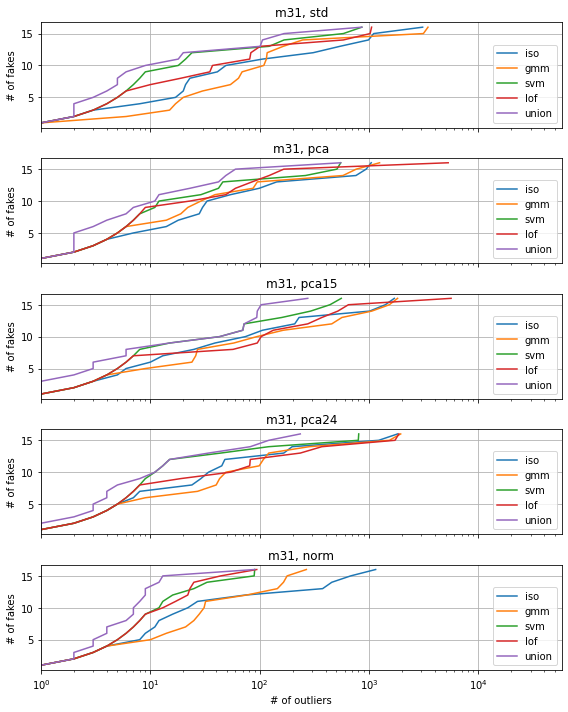

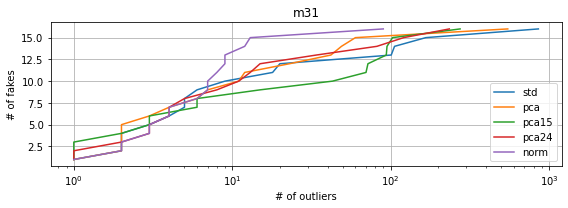

In [5]:
# Plot the fake curves

field = 'm31'
oid_len = os.stat(os.path.join(data_dir, 'oid_m31.dat')).st_size // 8
fig1, ax = plt.subplots(nrows=len(scalings), sharex=True, figsize=(8, 10))
fig2, bx = plt.subplots(figsize=(8, 3))
for i, scaling in enumerate(scalings):
    scores_dir = os.path.join(data_dir, 'scores_' + scaling)
    fake_tables = make_fake_tables(scores_dir, fake_dir, field, algos_for_fields[field])

    for algo, fake_table in fake_tables.items():
        ax[i].plot(fake_table['order'] + 1, np.arange(len(fake_table)) + 1, label=algo)

    ax[i].set(title='{}, {}'.format(field, scaling), ylabel='# of fakes')
    ax[i].set(xscale='log', xlim=[1, oid_len])
    ax[i].legend(loc='lower right')
    ax[i].grid()
    
    fake_table = fake_tables['union']
    bx.plot(fake_table['order'] + 1, np.arange(len(fake_table)) + 1, label=scaling)
#    display(pd.DataFrame({k: v['name'] for k, v in algo_to_fakes.items()}))

ax[-1].set(xlabel='# of outliers')
fig1.tight_layout()

bx.set(title='m31', ylabel='# of fakes', xlabel='# of outliers', xscale='log')
bx.legend(loc='lower right')
bx.grid()
fig2.tight_layout()

# Generating score files for different fields

## Score files may be downloaded
```shell
cd ../data
wget "http://sai.snad.space/ztf/scores.tar.gz" -O - | tar -zxf -
```

## Or they may be generated

In [ ]:
# Generate the score files for m31 field with different scalings
# WARNING: that may be a long run

scaling = 'std'
scores_dir = os.path.join(data_dir, 'scores')
os.makedirs(scores_dir, exist_ok=True)

for field in algos_for_fields.keys():
    for algo in algos_for_fields[field]:
        real_args = ['--oid', os.path.join(data_dir, 'oid_{}.dat'.format(field)),
                     '--feature', os.path.join(data_dir, 'feature_{}.dat'.format(field)),]
        fake_args = ['--oid', os.path.join(fake_dir, 'oid_{}_fake.dat'.format(field)),
                     '--feature', os.path.join(fake_dir, 'feature_{}_fake.dat'.format(field)),]

        score_file = os.path.join(scores_dir, 'score_{}_{}_fake.dat'.format(field, algo))
        score_args = ['--output', score_file]

        if os.path.exists(score_file):
            continue

        args = ['--jobs', jobs, '--scale', scaling, '--classifier', algo]
        args += real_args + fake_args + score_args
        ZtfAnomalyDetector(args).run()

# Plot the fake detection curves for fields

,iso,gmm,svm,lof,union
0,step,step,step,step,step
1,ZTF18abhjrcf_format_r,Gaia16aye_3_format_r,MACHO-6.6696.60_format_R,flat,MACHO-6.6696.60_format_R
2,Gaia16aye_3_format_r,ZTF18abhjrcf_format_r,Gaia16aye_3_format_r,MACHO-6.6696.60_format_R,ZTF18abhjrcf_format_r
3,ZTF18abaqxrt_format_r,MACHO-6.6696.60_format_R,ZTF18abhjrcf_format_r,flat_noise,flat
4,MACHO-6.6696.60_format_B,ZTF18abaqxrt_format_r,ZTF18abaqxrt_format_r,Gaia16aye_2_format_r,Gaia16aye_3_format_r
5,ZTF18aaztjyd_format_r,Gaia16aye_format_r,MACHO-6.6696.60_format_B,MACHO-6.6696.60_format_B,flat_noise
6,Gaia16aye_format_r,MACHO-6.6696.60_format_B,flat,Gaia16aye_3_format_r,Gaia16aye_2_format_r
7,Gaia16aye_2_format_r,Gaia16aye_2_format_r,Gaia16aye_2_format_r,ZTF18abaqxrt_format_r,ZTF18abaqxrt_format_r
8,MACHO-6.6696.60_format_R,flat,Gaia16aye_format_r,ZTF18acskgwu_format_r,MACHO-6.6696.60_format_B
9,ZTF18acskgwu_format_r,flat_noise,ZTF18acskgwu_format_r,ZTF18abhjrcf_format_r,Gaia16aye_format_r


,order,name
0,0,step
1,1,MACHO-6.6696.60_format_R
2,1,ZTF18abhjrcf_format_r
3,1,flat
4,2,Gaia16aye_3_format_r
5,3,flat_noise
6,4,Gaia16aye_2_format_r
7,4,ZTF18abaqxrt_format_r
8,5,MACHO-6.6696.60_format_B
9,8,Gaia16aye_format_r


,iso,gmm,svm,union
0,Gaia16aye_3_format_r,step,step,step
1,ZTF18abhjrcf_format_r,Gaia16aye_2_format_r,Gaia16aye_2_format_r,Gaia16aye_2_format_r
2,step,Gaia16aye_format_r,Gaia16aye_3_format_r,Gaia16aye_3_format_r
3,Gaia16aye_2_format_r,Gaia16aye_3_format_r,MACHO-6.6696.60_format_R,ZTF18abhjrcf_format_r
4,Gaia16aye_format_r,ZTF18abaqxrt_format_r,Gaia16aye_format_r,Gaia16aye_format_r
5,ZTF18acskgwu_format_r,ZTF18abhjrcf_format_r,ZTF18abaqxrt_format_r,MACHO-6.6696.60_format_R
6,ZTF18ablruzq_format_r,MACHO-6.6696.60_format_R,MACHO-6.6696.60_format_B,ZTF18abaqxrt_format_r
7,MACHO-6.6696.60_format_R,OGLE-LMC-CEP-0227_format_I,flat,MACHO-6.6696.60_format_B
8,ZTF18aaztjyd_format_r,ZTF18acskgwu_format_r,ZTF18abhjrcf_format_r,flat
9,ZTF18abaqxrt_format_r,flat,ZTF18acskgwu_format_r,ZTF18acskgwu_format_r


,order,name
0,0,step
1,2,Gaia16aye_2_format_r
2,2,Gaia16aye_3_format_r
3,3,ZTF18abhjrcf_format_r
4,4,Gaia16aye_format_r
5,4,MACHO-6.6696.60_format_R
6,7,ZTF18abaqxrt_format_r
7,11,MACHO-6.6696.60_format_B
8,13,flat
9,19,ZTF18acskgwu_format_r


,iso,gmm,union
0,step,step,step
1,ZTF18abhjrcf_format_r,Gaia16aye_3_format_r,Gaia16aye_3_format_r
2,MACHO-6.6696.60_format_B,Gaia16aye_format_r,ZTF18abhjrcf_format_r
3,Gaia16aye_format_r,ZTF18abhjrcf_format_r,Gaia16aye_format_r
4,MACHO-6.6696.60_format_R,OGLE-LMC-CEP-0227_format_V,MACHO-6.6696.60_format_B
5,Gaia16aye_3_format_r,ZTF18aaztjyd_format_r,OGLE-LMC-CEP-0227_format_V
6,ZTF18aaztjyd_format_r,MACHO-6.6696.60_format_B,ZTF18aaztjyd_format_r
7,ZTF18abaqxrt_format_r,MACHO-6.6696.60_format_R,MACHO-6.6696.60_format_R
8,ZTF18acskgwu_format_r,ZTF18abaqxrt_format_r,ZTF18abaqxrt_format_r
9,Gaia16aye_2_format_r,Gaia16aye_2_format_r,Gaia16aye_2_format_r


,order,name
0,6,step
1,30,Gaia16aye_3_format_r
2,44,ZTF18abhjrcf_format_r
3,45,Gaia16aye_format_r
4,65,MACHO-6.6696.60_format_B
5,65,OGLE-LMC-CEP-0227_format_V
6,70,ZTF18aaztjyd_format_r
7,130,MACHO-6.6696.60_format_R
8,190,ZTF18abaqxrt_format_r
9,198,Gaia16aye_2_format_r


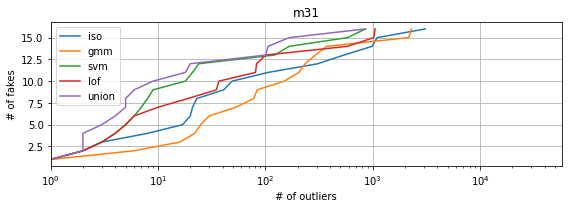

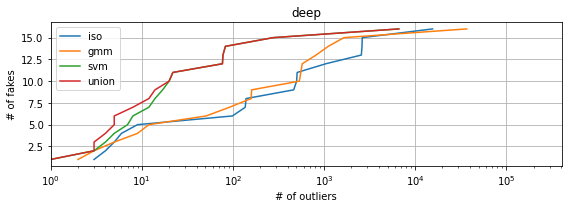

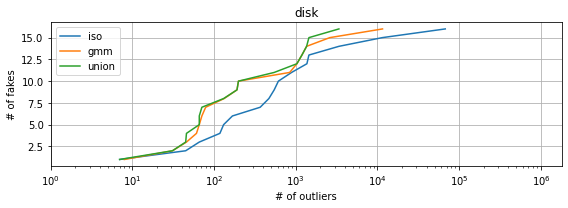

In [6]:
# Plot the fake curves for fields

scores_dir = os.path.join(data_dir, 'scores')
for field in algos_for_fields.keys():
    oid_len = os.stat(os.path.join(data_dir, 'oid_{}.dat'.format(field))).st_size // 8

    fake_tables = make_fake_tables(scores_dir, fake_dir, field, algos_for_fields[field])

    fig, ax = plt.subplots(figsize=(8, 3))
    for algo, fake_table in fake_tables.items():
        ax.plot(fake_table['order'] + 1, np.arange(len(fake_table)) + 1, label=algo)

    ax.set(title=field, ylabel='# of fakes', xlabel='# of outliers')
    ax.set(xscale='log', xlim=[1, oid_len])
    ax.legend(loc='upper left')
    ax.grid()
    fig.tight_layout()
    display(pd.DataFrame({k: v['name'] for k, v in fake_tables.items()}))
    display(fake_tables['union'])
    plt.savefig('../figs/fakes/{}_fakes.pdf'.format(field))

# Plot the cumulative score distributions

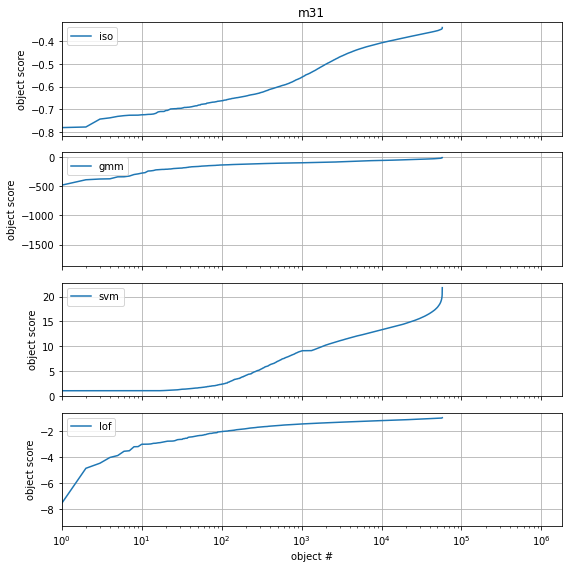

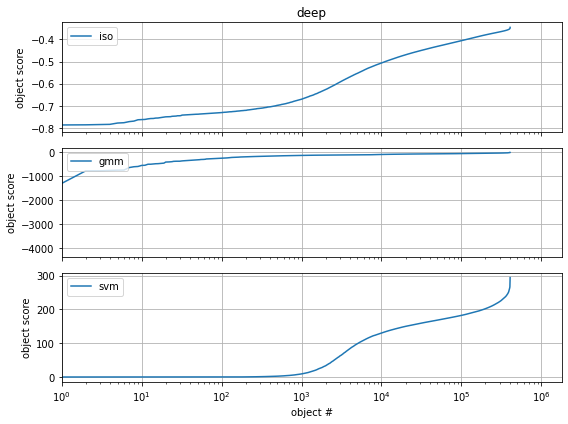

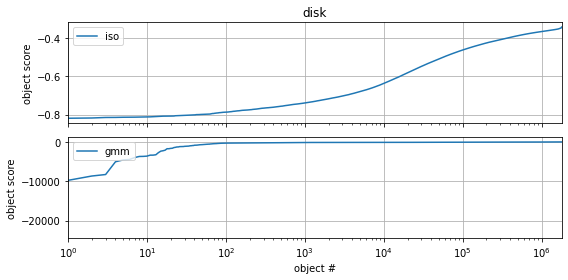

In [7]:
for field in algos_for_fields:
    algo_to_fakes = {}
    n = len(algos_for_fields[field])
    fig, ax = plt.subplots(n, 1, sharex=True, figsize=(8, 2 * n))
    for i, algo in enumerate(algos_for_fields[field]):
        scores = np.memmap('../data/scores/score_{}_{}_fake.dat'.format(field, algo), dtype=np.float64)
        ax[i].plot(np.arange(len(scores)), np.sort(scores), label=algo)
        ax[i].set(ylabel='object score')
        ax[i].legend(loc='upper left')
        ax[i].grid()

    ax[-1].set(xlabel='object #')
    ax[0].set(title=field)
    ax[0].set(xscale='log', xlim=[1, oid_len])
    fig.tight_layout()